In [75]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class RiverSwimEnv(gym.Env):
    def __init__(self, n_states=6, right_prob=0.4):
        super(RiverSwimEnv, self).__init__()
        self.n_states = n_states
        self.right_prob = right_prob
        self.n_actions = 2  # 0: left, 1: right
        self.action_space = gym.spaces.Discrete(self.n_actions)
        self.observation_space = gym.spaces.Discrete(self.n_states)
        self.P = self._build_transition_probabilities()
        self.state = 0

    def _build_transition_probabilities(self):
        P = {}
        for s in range(self.n_states):
            P[s] = {a: [] for a in range(self.n_actions)}
        
        P[0][0] = [(1.0, 0, 0, False)]
        P[0][1] = [(1 - self.right_prob, 0, 0, False), (self.right_prob, 1, 0, False)]
        
        for s in range(1, self.n_states - 1):
            P[s][0] = [(1.0, s - 1, 0, False)]
            P[s][1] = [(1 - self.right_prob, s, 0, False), (self.right_prob, s + 1, 0, False)]
        
        P[self.n_states - 1][0] = [(1.0, self.n_states - 2, 0, False)]
        P[self.n_states - 1][1] = [(1 - self.right_prob, self.n_states - 1, 1, False), (self.right_prob, self.n_states - 1, 1, False)]
        
        return P

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        transitions = self.P[self.state][action]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, next_state, reward, done = transitions[i]
        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass

# Register the custom environment
gym.envs.registration.register(
    id='RiverSwim-v0',
    entry_point='__main__:RiverSwimEnv',
)

/Users/yanis/miniforge3/envs/cs234_hw3/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RiverSwim-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [76]:
class SixArmsEnv(gym.Env):
    def __init__(self, n_arms=6, transition_prob=0.2):
        super(SixArmsEnv, self).__init__()
        self.n_arms = n_arms
        self.transition_prob = transition_prob
        self.n_actions = n_arms  # One action for each arm
        self.action_space = gym.spaces.Discrete(self.n_actions)
        self.observation_space = gym.spaces.Discrete(2)  # Two states: center (0) and arm (1)
        self.P = self._build_transition_probabilities()
        self.state = 0

    def _build_transition_probabilities(self):
        P = {0: {a: [] for a in range(self.n_actions)}, 1: {a: [] for a in range(self.n_actions)}}
        
        # Transitions from the center (state 0)
        for a in range(self.n_actions):
            P[0][a] = [(self.transition_prob, 1, 1, False), (1 - self.transition_prob, 0, 0, False)]
        
        # Transitions from an arm (state 1)
        for a in range(self.n_actions):
            P[1][a] = [(1.0, 0, 0, False)]
        
        return P

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        transitions = self.P[self.state][action]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, next_state, reward, done = transitions[i]
        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass

# Register the custom environment
gym.envs.registration.register(
    id='SixArms-v0',
    entry_point='__main__:SixArmsEnv',
)

In [77]:
class RandomMDPEnv(gym.Env):
    def __init__(self, n_states=5, n_actions=2, seed=None):
        super(RandomMDPEnv, self).__init__()
        self.n_states = n_states
        self.n_actions = n_actions
        self.action_space = gym.spaces.Discrete(self.n_actions)
        self.observation_space = gym.spaces.Discrete(self.n_states)
        
        if seed is not None:
            np.random.seed(seed)
        
        self.P = self._build_transition_probabilities()
        self.rewards = self._build_rewards()
        self.state = 0

    def _build_transition_probabilities(self):
        P = {}
        for s in range(self.n_states):
            P[s] = {a: [] for a in range(self.n_actions)}
            for a in range(self.n_actions):
                next_states = np.random.choice(self.n_states, self.n_states, replace=False)
                probabilities = np.random.dirichlet(np.ones(self.n_states))
                for prob, next_state in zip(probabilities, next_states):
                    P[s][a].append((prob, next_state, 0, False))
        return P

    def _build_rewards(self):
        rewards = np.random.uniform(-1, 1, (self.n_states, self.n_actions))
        return rewards

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        transitions = self.P[self.state][action]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, next_state, reward, done = transitions[i]
        reward = self.rewards[self.state, action]
        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass

# Register the custom environment
gym.envs.registration.register(
    id='RandomMDP-v0',
    entry_point='__main__:RandomMDPEnv',
)

In [78]:
class GarnetMDPEnv(gym.Env):
    def __init__(self, n_states=10, n_actions=3, sparsity=2):
        super(GarnetMDPEnv, self).__init__()
        self.n_states = n_states
        self.n_actions = n_actions
        self.sparsity = sparsity  # Number of non-zero transitions per state-action pair
        self.action_space = gym.spaces.Discrete(self.n_actions)
        self.observation_space = gym.spaces.Discrete(self.n_states)
        self.P, self.R = self._build_transition_probabilities_and_rewards()
        self.state = 0

    def _build_transition_probabilities_and_rewards(self):
        P = {s: {a: [] for a in range(self.n_actions)} for s in range(self.n_states)}
        R = {s: {a: [] for a in range(self.n_actions)} for s in range(self.n_states)}
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                next_states = np.random.choice(self.n_states, self.sparsity, replace=False)
                probs = np.random.dirichlet(np.ones(self.sparsity))
                rewards = np.random.rand(self.sparsity)
                
                for next_state, prob, reward in zip(next_states, probs, rewards):
                    P[s][a].append((prob, next_state, reward, False))
                    R[s][a].append(reward)
        
        return P, R

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        transitions = self.P[self.state][action]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, next_state, reward, done = transitions[i]
        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass

# Register the custom environment
gym.envs.registration.register(
    id='GarnetMDP-v0',
    entry_point='__main__:GarnetMDPEnv',
)

In [79]:
def policy_evaluation(policy, env, gamma, theta, n_states, n_actions):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
    return V

def policy_improvement(V, env, gamma, n_states, n_actions):
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        Q = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[a] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(Q)
        policy[s, best_action] = 1.0
    return policy

def policy_iteration(env, gamma, theta, n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    while True:
        V = policy_evaluation(policy, env, gamma, theta, n_states, n_actions)
        new_policy = policy_improvement(V, env, gamma, n_states, n_actions)
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy
    return policy, V

def value_function(policy, env, gamma, n_states, n_actions):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < 1e-6:
            break
    return V

def fisher_information_matrix(policy, env, gamma, V, n_states, n_actions):
    FIM = np.zeros((n_states * n_actions, n_states * n_actions))
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[s, a] += prob * (reward + gamma * V[next_state])
    for s in range(n_states):
        grad = Q[s] - np.sum(policy[s] * Q[s])
        grad = grad[:, np.newaxis]
        for i in range(n_actions):
            for j in range(n_actions):
                FIM[s * n_actions + i, s * n_actions + j] = np.sum(grad[i] * grad[j] * policy[s, i] * policy[s, j])
    return FIM

def policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_star, s0, epsilon, n_states, n_actions):
    V_history = []  # List to store value function at each iteration
    for i in tqdm(range(num_iterations)):
        V = value_function(policy, env, gamma, n_states, n_actions)
        V_history.append(V.copy())  # Store the current value of V
        Q = np.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    Q[s, a] += prob * (reward + gamma * V[next_state])

        FIM = fisher_information_matrix(policy, env, gamma, V, n_states, n_actions)
        FIM_inv = np.linalg.pinv(FIM)  # Compute the pseudo-inverse of FIM
        
        # Policy Gradient Ascent with Natural Gradient
        for s in range(n_states):
            grad = Q[s] - np.sum(policy[s] * Q[s])
            nat_grad = np.dot(FIM_inv[s * n_actions:(s + 1) * n_actions, s * n_actions:(s + 1) * n_actions], grad)
            policy[s] = policy[s] + alpha * nat_grad
            policy[s] = np.maximum(policy[s], 0)
            policy[s] /= np.sum(policy[s])  # Project back to simplex
        
        # Check if we are within epsilon of the optimal value function
        if abs(V_star[s0] - V[s0]) <= epsilon:
            print(f"Stopping early at iteration {i} as V(s0) is within epsilon of V*(s0).")
            print(f"V*(s0): {V_star[s0]}, V(s0): {V[s0]}, Difference: {V_star[s0] - V[s0]}")
            break
    return policy, V, V_history

In [61]:
# Create the environment with custom parameters
env = gym.make('RiverSwim-v0', n_states=10, right_prob=0.8)
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = np.ones((n_states, n_actions)) / n_actions
gamma = 0.9  # discount factor
theta = 1e-3  # threshold for policy evaluation

# Perform policy iteration to find the optimal policy and value function
optimal_policy, V_star = policy_iteration(env, gamma, theta, n_states, n_actions)
V_optimal = policy_evaluation(optimal_policy, env, gamma, theta, n_states, n_actions)
print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Function V*:")
print(V_optimal)
# Select the starting state s0
s0 = 0
print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[3.09359069 3.52444982 4.0151505  4.57400404 5.21047614 5.93534714
 6.76089466 7.70110156 8.77189276 9.99140496]
V*(s0) for s0 = 0: 3.0935906901694747


  0%|          | 13/3000 [00:00<00:29, 100.18it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 3.0935906901694747, V(s0): 3.1021775264165434, Difference: -0.008586836247068685


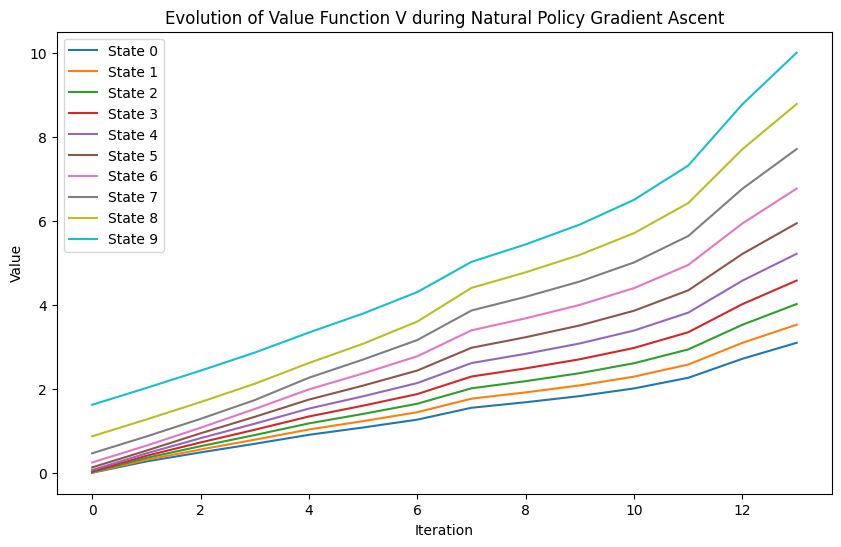

Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[3.10217753 3.53303666 4.02373733 4.58259088 5.21906297 5.94393397
 6.7694815  7.7096884  8.7804796  9.99999179]
V*(s0) for s0 = 0: 3.0935906901694747
V(s0) for s0 = 0: 3.1021775264165434
Difference: -0.008586836247068685
Iterations: 14


In [62]:
# Define constants
epsilon = 0.1
alpha = 0.01  # learning rate
gamma = 0.9  # discount factor
num_iterations = 3000

# Create the environment
n_states = env.observation_space.n
n_actions = env.action_space.n
s0 = 0  # Starting state

# Initialize policy
policy = np.ones((n_states, n_actions)) / n_actions

# Optimize policy using Natural Policy Gradient Ascent
optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon, n_states, n_actions)

# Plot the evolution of V
plt.figure(figsize=(10, 6))
for s in range(n_states):
    plt.plot([V[s] for V in V_history], label=f'State {s}')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Evolution of Value Function V during Natural Policy Gradient Ascent')
plt.legend()
plt.show()

print("Optimized Policy:")
print(optimized_policy)
print("Value Function of Optimized Policy:")
print(V_opt)

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
print(f"V(s0) for s0 = {s0}: {V_opt[s0]}")
print(f"Difference: {V_optimal[s0] - V_opt[s0]}")
print("Iterations:", len(V_history))

In [63]:
# Assume initial state distribution is uniform
mu = np.ones(n_states) / n_states

# Calculate stationary distribution d_pi for the optimal policy
def compute_stationary_distribution(policy, env, gamma, theta):
    P = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                P[s, next_state] += policy[s, a] * prob
    
    # Solve for stationary distribution
    A = np.eye(n_states) - gamma * P.T
    b = np.ones(n_states)
    d_pi = np.linalg.solve(A, b)
    d_pi /= np.sum(d_pi)  # Normalize
    return d_pi

d_pi_star = compute_stationary_distribution(optimal_policy, env, gamma, theta)

# Compute the distribution mismatch coefficient
distribution_mismatch = np.max(np.abs(d_pi_star / mu))

print("Distribution mismatch coefficient:")
print(distribution_mismatch)


Distribution mismatch coefficient:
5.966426270996817


In [64]:
# Theoretical iteration complexity calculations
D_inf = distribution_mismatch
S = env.observation_space.n
A = env.action_space.n
gamma = 0.9
epsilon = 0.1

def theoretical_iterations_pga(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S * A) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_spg(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S**2 * A**2) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_npg(gamma, epsilon):
    return 2 / ((1 - gamma)**2 * epsilon)

# Theoretical iterations
theoretical_pga = theoretical_iterations_pga(D_inf, S, A, gamma, epsilon)
theoretical_spg = theoretical_iterations_spg(D_inf, S, A, gamma, epsilon)
theoretical_npg = theoretical_iterations_npg(gamma, epsilon)

# Print theoretical results
print(f"Theoretical Projected Gradient Ascent: {theoretical_pga}")
print(f"Theoretical Softmax Policy Gradient: {theoretical_spg}")
print(f"Theoretical Natural Policy Gradient: {theoretical_npg}")

Theoretical Projected Gradient Ascent: 71196484894.48204
Theoretical Softmax Policy Gradient: 1423929697889.641
Theoretical Natural Policy Gradient: 2000.000000000001


In [98]:
gamma = 0.9
theta = 1e-3
s0 = 0
epsilon = 0.1
alpha = 0.01
num_iterations = 10000
n_states = 10
right_prob = 0.6
store_iterations = {}
gamma_values = np.array([0.7, 0.8, 0.85, 0.9, 0.95, 0.99])
epsilon_values = np.logspace(-3, 0, 4)  # 10 values from 1e-3 to 1e3


for gamma in gamma_values:
    for epsilon in epsilon_values:
        for n_states in [10, 20, 40]:
            print(f"Gamma: {gamma}, Epsilon: {epsilon}, n_states: {n_states}")
            env = gym.make('RiverSwim-v0', n_states=n_states, right_prob=right_prob)
            n_states = env.observation_space.n
            n_actions = env.action_space.n

            optimal_policy, V_star = policy_iteration(env, gamma, theta, n_states, n_actions)
            V_optimal = policy_evaluation(optimal_policy, env, gamma, theta, n_states, n_actions)
            print("Optimal Policy:")
            print(optimal_policy)
            print("Optimal Value Function V*:")
            print(V_optimal)
            print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")


            policy = np.ones((n_states, n_actions)) / n_actions
            optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon, n_states, n_actions)
            print("Optimized Policy:")
            print(optimized_policy)
            print("Value Function of Optimized Policy:")
            print(V_opt)

            print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
            print(f"V(s0) for s0 = {s0}: {V_opt[s0]}")
            print(f"Difference: {V_optimal[s0] - V_opt[s0]}")
            print("Iterations:", len(V_history))
            store_iterations[(gamma, epsilon, n_states)] = len(V_history)


/Users/yanis/miniforge3/envs/cs234_hw3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


Gamma: 0.7, Epsilon: 0.001, n_states: 10
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.06829745 0.10588274 0.16360304 0.25224493 0.38837354 0.5974282
 0.91847643 1.41151478 2.16868082 3.33147151]
V*(s0) for s0 = 0: 0.06829745188248647


100%|██████████| 10000/10000 [00:36<00:00, 277.43it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.07015713 0.10774244 0.16546274 0.25410463 0.39023324 0.5992879
 0.92033613 1.41337448 2.17054051 3.33333121]
V*(s0) for s0 = 0: 0.06829745188248647
V(s0) for s0 = 0: 0.07015712601165708
Difference: -0.0018596741291706104
Iterations: 10000
Gamma: 0.7, Epsilon: 0.001, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603041e-01 2.52244929e-01 3.88373545e-01 5.97428204e-01
 9.18476432e-01 1.41151478e+00 2.16868082e+00 3.33147151e+00]
V*(s0) for s0 = 0: 7.162407106446997e-05


  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 7.162407106446997e-05, V(s0): 2.0751737507148962e-10, Difference: 7.16238635470949e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702643 0.73297357]
 [0.4193503  0.5806497 ]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[2.07517375e-10 1.16309669e-09 5.60613612e-09 2.29493179e-08
 8.33421961e-08 2.78140764e-07 8.76323693e-07 2.65971803e-06
 7.88998356e-06 2.31007142e-05 6.71623913e-05 1.94579947e-04
 5.62793730e-04 1.62659397e-03 4.69972924e-03 1.35772313e-02
 3.92218406e-02 1.13301728e-01 3.27297

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

  0%|          | 11/10000 [00:00<00:54, 181.83it/s]


Stopping early at iteration 11 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.06829745188248647, V(s0): 0.06948102626189837, Difference: -0.0011835743794118975
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.06948103 0.10670408 0.16386806 0.2516556  0.38647217 0.5935119
 0.91146578 1.39975208 2.14962034 3.30120372]
V*(s0) for s0 = 0: 0.06829745188248647
V(s0) for s0 = 0: 0.06948102626189837
Difference: -0.0011835743794118975
Iterations: 12
Gamma: 0.7, Epsilon: 0.01, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).

  0%|          | 0/10000 [00:00<?, ?it/s]


V*(s0): 7.162407106446997e-05, V(s0): 2.0751737507148962e-10, Difference: 7.16238635470949e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702643 0.73297357]
 [0.4193503  0.5806497 ]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[2.07517375e-10 1.16309669e-09 5.60613612e-09 2.29493179e-08
 8.33421961e-08 2.78140764e-07 8.76323693e-07 2.65971803e-06
 7.88998356e-06 2.31007142e-05 6.71623913e-05 1.94579947e-04
 5.62793730e-04 1.62659397e-03 4.69972924e-03 1.35772313e-02
 3.92218406e-02 1.13301728e-01 3.27297035e-01 9.45467312e-01]
V*(s0) for s0 = 0: 7.162407106446997e-05
V(

Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.19942197e-06
 7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603041e-01 2.52244929e-01 3.88373545e-01 5.97428204e-01
 9.18476432e-01 1.41151478e+00 2.16868082e+00 3

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0


Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702643 0.73297357]
 [0.4193503  0.5806497 ]
 [0.472

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.06829745188248647, V(s0): 9.987393266942356e-05, Difference: 0.06819757794981704
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702628 0.73297372]
 [0.41935029 0.58064971]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[9.98739327e-05 2.08649628e-04 5.68839523e-04 1.62918917e-03
 4.70084200e-03 1.35777079e-02 3.92220445e-02 1.13301815e-01
 3.27297073e-01 9.45467332e-01]
V*(s0) for s0 = 0: 0.06829745188248647
V(s0) for s0 = 0: 9.987393266942356e-05
Difference: 0.06819757794981704
Iterations: 1
Gamma: 0.7, Epsilon: 0.1, n_states: 20


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603041e-01 2.52244929e-01 3.88373545e-01 5.97428204e-01
 9.18476432e-01 1.41151478e+00 2.16868082e+00 3.33147151e+00]
V*(s0) for s0 = 0: 7.162407106446997e-05


  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 7.162407106446997e-05, V(s0): 2.0751737507148962e-10, Difference: 7.16238635470949e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702643 0.73297357]
 [0.4193503  0.5806497 ]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[2.07517375e-10 1.16309669e-09 5.60613612e-09 2.29493179e-08
 8.33421961e-08 2.78140764e-07 8.76323693e-07 2.65971803e-06
 7.88998356e-06 2.31007142e-05 6.71623913e-05 1.94579947e-04
 5.62793730e-04 1.62659397e-03 4.69972924e-03 1.35772313e-02
 3.92218406e-02 1.13301728e-01 3.27297

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.06829745188248647, V(s0): 9.987393266942356e-05, Difference: 0.06819757794981704
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702628 0.73297372]
 [0.41935029 0.58064971]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[9.98739327e-05 2.08649628e-04 5.68839523e-04 1.62918917e-03
 4.70084200e-03 1.35777079e-02 3.92220445e-02 1.13301815e-01
 3.27297073e-01 9.45467332e-01]
V*(s0) for s0 = 0: 0.06829745188248647
V(s0) for s0 = 0: 9.987393266942356e-05
Difference: 0.06819757794981704
Iterations: 1
Gamma: 0.7, Epsilon: 1.0, n_states: 20


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603041e-01 2.52244929e-01 3.88373545e-01 5.97428204e-01
 9.18476432e-01 1.41151478e+00 2.16868082e+00 3.33147151e+00]
V*(s0) for s0 = 0: 7.162407106446997e-05


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 7.162407106446997e-05, V(s0): 2.0751737507148962e-10, Difference: 7.16238635470949e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26702643 0.73297357]
 [0.4193503  0.5806497 ]
 [0.47208106 0.52791894]]
Value Function of Optimized Policy:
[2.07517375e-10 1.16309669e-09 5.60613612e-09 2.29493179e-08
 8.33421961e-08 2.78140764e-07 8.76323693e-07 2.65971803e-06
 7.88998356e-06 2.31007142e-05 6.71623913e-05 1.94579947e-04
 5.62793730e-04 1.62659397e-03 4.69972924e-03 1.35772313e-02
 3.92218406e-02 1.13301728e-01 3.27297

Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.19942197e-06
 7.16240711e-05 2.88232910e-04 8.12057686e-04 1.83157530e-03
 3.58007463e-03 6.38714440e-03 1.07632914e-02 1.75123671e-02
 2.78873341e-02 4.38234135e-02 6.82974519e-02 1.05882743e-01
 1.63603041e-01 2.52244929e-01 3.88373545e-01 5.97428204e-01
 9.18476432e-01 1.41151478e+00 2.16868082e+00 3

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

100%|██████████| 10000/10000 [00:53<00:00, 187.75it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.4325858  0.56777009 0.74519946 0.97807552 1.28372535 1.68489075
 2.21142033 2.90249041 3.80951989 4.99999608]
V*(s0) for s0 = 0: 0.42862831279079494
V(s0) for s0 = 0: 0.4325857977278913
Difference: -0.003957484937096356
Iterations: 10000
Gamma: 0.8, Epsilon: 0.001, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.02455657 0.03346602 0.0451614  0.06051209 0.08066002 0.10710421
 0.14181221 0.18736647 0.24715643 0.32563076 0.42862831 0.5638126
 0.74124198 0.97411804 1.27976786 1.68093326 2.20746284 2.89853292
 3.8055624  4.99603859]
V*(s0) for s0 = 0: 0.024556568105413127


  0%|          | 11/10000 [00:00<01:35, 104.68it/s]


Stopping early at iteration 11 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.024556568105413127, V(s0): 0.023939123860334213, Difference: 0.0006174442450789137
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.02393912 0.03142123 0.04124147 0.05413051 0.07104735 0.09325068
 0.12239253 0.16064119 0.21084253 0.27673177 0.36321137 0.47671583
 0.62569041 0.82121953 1.07785148 1.4146809  1.85676949 2.43701075
 3.19857739 4.19813358]
V*(s0) for s0 = 0: 0.024556568105413127
V(s0) for s0 = 0: 0.023939123860334213
Difference: 0.0006174442450789137
Iterations: 12
Gamma: 0.8, Epsilon: 0.001, n_states: 40
Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0.

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

  0%|          | 12/10000 [00:00<01:16, 130.91it/s]


Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.42862831279079494, V(s0): 0.4325857977278913, Difference: -0.003957484937096356
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.4325858  0.56777009 0.74519946 0.97807552 1.28372535 1.68489075
 2.21142033 2.90249041 3.80951989 4.99999608]
V*(s0) for s0 = 0: 0.42862831279079494
V(s0) for s0 = 0: 0.4325857977278913
Difference: -0.003957484937096356
Iterations: 13
Gamma: 0.8, Epsilon: 0.01, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.02455657 0.03346602 0.0451614  0.06051209 0.08066002 0.10710421
 0.14181221 0.18736647 0.24715643 0.32563076 0.42862831 0.5638126
 0.74124198 0.97411804 1.27976786 1.68093326 2.20746284 2.898

  0%|          | 7/10000 [00:00<02:22, 69.89it/s]

Stopping early at iteration 7 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.024556568105413127, V(s0): 0.015544166260674282, Difference: 0.009012401844738845
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26194901 0.73805099]]
Value Function of Optimized Policy:
[0.01554417 0.02040277 0.02677961 0.03514914 0.04613409 0.06055178
 0.07947494 0.10431154 0.13690953 0.17969434 0.23584936 0.3095528
 0.40628852 0.53325411 0.69989643 0.91861445 1.20568181 1.5824577
 2.07697604 2.72603134]
V*(s0) for s0 = 0: 0.024556568105413127
V(s0) for s0 = 0: 0.01

Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.80797146e-07 1.01144706e-05 5.25071285e-05 1.84159271e-04
 4.94724057e-04 1.09522023e-03 2.10036133e-03 3.62109962e-03
 5.77448315e-03 8.70574206e-03 1.26133616e-02 1.77722834e-02
 2.45565681e-02 3.34660187e-02 4.51613950e-02 6.05120932e-02
 8.06600219e-02 1.07104211e-01 1.41812215e-01 1.87366472e-01
 2.47156434e-01 3.25630760e-01 4.28628313e-01 5.63812601e-01
 7.41241978e-01 9.74118037e-01 1.27976786e+00 1.68093326e+00
 2.20746284e+00 2.89853292e+00 3.80556240e+00 4

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

  0%|          | 11/10000 [00:00<01:02, 158.71it/s]

Stopping early at iteration 11 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.42862831279079494, V(s0): 0.3632107502903953, Difference: 0.06541756250039965
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.36321075 0.47671526 0.62568991 0.82121911 1.07785116 1.4146807
 1.85676945 2.43701091 3.19857781 4.19813434]
V*(s0) for s0 = 0: 0.42862831279079494
V(s0) for s0 = 0: 0.3632107502903953
Difference: 0.06541756250039965
Iterations: 12
Gamma: 0.8, Epsilon: 0.1, n_states: 20


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.02455657 0.03346602 0.0451614  0.06051209 0.08066002 0.10710421
 0.14181221 0.18736647 0.24715643 0.32563076 0.42862831 0.5638126
 0.74124198 0.97411804 1.27976786 1.68093326 2.20746284 2.89853292
 3.8055624  4.99603859]
V*(s0) for s0 = 0: 0.024556568105413127


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.024556568105413127, V(s0): 1.1177348066248421e-07, Difference: 0.024556456331932465
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.16543315 0.83456685]
 [0.35708705 0.64291295]
 [0.43895355 0.56104645]
 [0.4739235  0.5260765 ]]
Value Function of Optimized Policy:
[1.11773481e-07 2.20605119e-07 5.27854491e-07 1.29531697e-06
 3.14817805e-06 7.55831035e-06 1.79770763e-05 4.24876124e-05
 1.00013872e-04 2.34856179e-04 5.50719744e-04 1.29037753e-03
 3.02216573e-03 7.07658027e-03 1.65683727e-02 3.87893310e-02
 9.08099036e-02 2.12592895e-01 4.976933

Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.80797146e-07 1.01144706e-05 5.25071285e-05 1.84159271e-04
 4.94724057e-04 1.09522023e-03 2.10036133e-03 3.62109962e-03
 5.77448315e-03 8.70574206e-03 1.26133616e-02 1.77722834e-02
 2.45565681e-02 3.34660187e-02 4.51613950e-02 6.05120932e-02
 8.06600219e-02 1.07104211e-01 1.41812215e-01 1.87366472e-01
 2.47156434e-01 3.25630760e-01 4.28628313e-01 5.63812601e-01
 7.41241978e-01 9.74118037e-01 1.27976786e+00 1.68093326e+00
 2.20746284e+00 2.89853292e+00 3.80556240e+00 4

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.42862831279079494, V(s0): 0.0009111819170723472, Difference: 0.4277171308737226
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.16541034 0.83458966]
 [0.35708488 0.64291512]
 [0.43895335 0.56104665]
 [0.47392348 0.52607652]]
Value Function of Optimized Policy:
[9.11181917e-04 1.48290087e-03 3.12515346e-03 7.13185761e-03
 1.65982454e-02 3.88056913e-02 9.08190936e-02 2.12598308e-01
 4.97696793e-01 1.16513092e+00]
V*(s0) for s0 = 0: 0.42862831279079494
V(s0) for s0 = 0: 0.0009111819170723472
Difference: 0.4277171308737226
Iterations: 1
Gamma: 0.8, Epsilon: 1.0, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function 

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.024556568105413127, V(s0): 1.1177348066248421e-07, Difference: 0.024556456331932465
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.16543315 0.83456685]
 [0.35708705 0.64291295]
 [0.43895355 0.56104645]
 [0.4739235  0.5260765 ]]
Value Function of Optimized Policy:
[1.11773481e-07 2.20605119e-07 5.27854491e-07 1.29531697e-06
 3.14817805e-06 7.55831035e-06 1.79770763e-05 4.24876124e-05
 1.00013872e-04 2.34856179e-04 5.50719744e-04 1.29037753e-03
 3.02216573e-03 7.07658027e-03 1.65683727e-02 3.87893310e-02
 9.08099036e-02 2.12592895e-01 4.976933

Optimal Policy:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.80797146e-07 1.01144706e-05 5.25071285e-05 1.84159271e-04
 4.94724057e-04 1.09522023e-03 2.10036133e-03 3.62109962e-03
 5.77448315e-03 8.70574206e-03 1.26133616e-02 1.77722834e-02
 2.45565681e-02 3.34660187e-02 4.51613950e-02 6.05120932e-02
 8.06600219e-02 1.07104211e-01 1.41812215e-01 1.87366472e-01
 2.47156434e-01 3.25630760e-01 4.28628313e-01 5.63812601e-01
 7.41241978e-01 9.74118037e-01 1.27976786e+00 1.68093326e+00
 2.20746284e+00 2.89853292e+00 3.80556240e+00 4

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.0, V(s0): 0.0, Difference: 0.0
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        

100%|██████████| 10000/10000 [01:12<00:00, 137.88it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[1.10862389 1.35317435 1.65166975 2.01600973 2.46071882 3.00352551
 3.66606897 4.47476171 5.46184257 6.66666184]
V*(s0) for s0 = 0: 1.103400645822464
V(s0) for s0 = 0: 1.10862389334577
Difference: -0.0052232475233058295
Iterations: 10000
Gamma: 0.85, Epsilon: 0.001, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.14581275 0.17913057 0.21979792 0.26943601 0.33002367 0.40397626
 0.49424193 0.60441913 0.73890013 0.90304606 1.10340065 1.3479511
 1.6464465  2.01078648 2.45549558 2.99830226 3.66084572 4.46953847
 5.45661932 6.6614386 ]
V*(s0) for s0 = 0: 0.14581274645328832


100%|██████████| 10000/10000 [02:23<00:00, 69.65it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.15103599 0.18435382 0.22502117 0.27465926 0.33524692 0.40919951
 0.49946517 0.60964238 0.74412338 0.90826931 1.10862389 1.35317435
 1.65166975 2.01600973 2.46071882 3.00352551 3.66606897 4.47476171
 5.46184257 6.66666184]
V*(s0) for s0 = 0: 0.14581274645328832
V(s0) for s0 = 0: 0.15103599396038261
Difference: -0.005223247507094297
Iterations: 10000
Gamma: 0.85, Epsilon: 0.001, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 8.02283056139595e-05, V(s0): 2.670839367401597e-19, Difference: 8.022830561395923e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.     

  0%|          | 12/10000 [00:00<02:17, 72.72it/s]

Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 1.103400645822464, V(s0): 1.10862389334577, Difference: -0.0052232475233058295
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[1.10862389 1.35317435 1.65166975 2.01600973 2.46071882 3.00352551
 3.66606897 4.47476171 5.46184257 6.66666184]
V*(s0) for s0 = 0: 1.103400645822464
V(s0) for s0 = 0: 1.10862389334577
Difference: -0.0052232475233058295
Iterations: 13
Gamma: 0.85, Epsilon: 0.01, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.14581275 0.17913057 0.21979792 0.26943601 0.33002367 0.40397626
 0.49424193 0.60441913 0.73890013 0.90304606 1.10340065 1.3479511
 1.6464465  2.01078648 2.45549558 2.99830226 3.66084572 4.46953847


  0%|          | 12/10000 [00:00<02:08, 77.99it/s]


Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.14581274645328832, V(s0): 0.15103599396038261, Difference: -0.005223247507094297
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.15103599 0.18435382 0.22502117 0.27465926 0.33524692 0.40919951
 0.49946517 0.60964238 0.74412338 0.90826931 1.10862389 1.35317435
 1.65166975 2.01600973 2.46071882 3.00352551 3.66606897 4.47476171
 5.46184257 6.66666184]
V*(s0) for s0 = 0: 0.14581274645328832
V(s0) for s0 = 0: 0.15103599396038261
Difference: -0.005223247507094297
Iterations: 13
Gamma: 0.85, Epsilon: 0.01, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 8.02283056139595e-05, V(s0): 2.670839367401597e-19, Difference: 8.022830561395923e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.     

  0%|          | 12/10000 [00:00<01:59, 83.47it/s]

Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 1.103400645822464, V(s0): 1.10862389334577, Difference: -0.0052232475233058295
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[1.10862389 1.35317435 1.65166975 2.01600973 2.46071882 3.00352551
 3.66606897 4.47476171 5.46184257 6.66666184]
V*(s0) for s0 = 0: 1.103400645822464
V(s0) for s0 = 0: 1.10862389334577
Difference: -0.0052232475233058295
Iterations: 13
Gamma: 0.85, Epsilon: 0.1, n_states: 20


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.14581275 0.17913057 0.21979792 0.26943601 0.33002367 0.40397626
 0.49424193 0.60441913 0.73890013 0.90304606 1.10340065 1.3479511
 1.6464465  2.01078648 2.45549558 2.99830226 3.66084572 4.46953847
 5.45661932 6.6614386 ]
V*(s0) for s0 = 0: 0.14581274645328832


  0%|          | 4/10000 [00:00<02:28, 67.23it/s]


Stopping early at iteration 4 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.14581274645328832, V(s0): 0.04938694063205596, Difference: 0.09642580582123236
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.17928897 0.82071103]
 [0.37023338 0.62976662]]
Value Function of Optimized Policy:
[0.04938694 0.0602822  0.07358075 0.08981271 0.10962518 0.13380797
 0.16332515 0.1993534  0.24332902 0.29700509 0.36252142 0.44248984
 0.54009832 0.65923805 0.80465857 0.98215711 1.19880972 1.46325332
 1.78603004 2.47098091]
V*(s0) for s0 = 0: 0.14581274645328832
V(s0) for s0 = 0: 0.0493

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 8.02283056139595e-05, V(s0): 2.670839367401597e-19, Difference: 8.022830561395923e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.     

  0%|          | 1/10000 [00:00<01:33, 107.43it/s]


Stopping early at iteration 1 as V(s0) is within epsilon of V*(s0).
V*(s0): 1.103400645822464, V(s0): 0.12401119865741039, Difference: 0.9793894471650537
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.26884835 0.73115165]
 [0.39390437 0.60609563]
 [0.44977528 0.55022472]]
Value Function of Optimized Policy:
[0.1240112  0.15136762 0.18475843 0.22551475 0.27526135 0.33598138
 0.4127807  0.57295922 0.90827    1.6104609 ]
V*(s0) for s0 = 0: 1.103400645822464
V(s0) for s0 = 0: 0.12401119865741039
Difference: 0.9793894471650537
Iterations: 2
Gamma: 0.85, Epsilon: 1.0, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.14581275 0.17913057 0.21979792 0.26943601

  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.14581274645328832, V(s0): 1.5848679660561412e-06, Difference: 0.14581116158532226
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.01808165 0.98191835]
 [0.26989363 0.73010637]
 [0.39012872 0.60987128]
 [0.4475386  0.5524614 ]
 [0.4749507  0.5250493 ]]
Value Function of Optimized Policy:
[1.58486797e-06 2.43481385e-06 4.66042037e-06 9.61181374e-06
 2.01907591e-05 4.25186590e-05 8.94417983e-05 1.87879342e-04
 3.94216389e-04 8.26544356e-04 1.73218425e-03 3.62910337e-03
 7.60208868e-03 1.59230310e-02 3.33500027e-02 6.98479502e-02
 1.46286710e-01 3.06374511e-01 6.41650614

Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[8.02283056e-05 2.15271658e-04 4.88314554e-04 9.68444702e-04
 1.72428955e-03 2.81666851e-03 4.29859161e-03 6.22221992e-03
 8.64911017e-03 1.16599175e-02 1.53617625e-02 1.98936354e-02
 2.54312782e-02 3.21929683e-02 4.04471484e-02 5.05224253e-02
 6.28202904e-02 7.78309486e-02 9.61527888e-02 1.18516213e-01
 1.45812746e-01 1.79130574e-01 2.19797922e-01 2.69436009e-01
 3.30023673e-01 4.03976264e-01 4.94241926e-01 6.04419131e-01
 7.38900131e-01 9.03046058e-01 1.10340065e+00 1.34795110e+00
 1.64644650e+00 2.01078648e+00 2.45549558e+00 2.99830226e+00
 3.66084572e+00 4.46953847e+00 5.45661932e+00 6

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 8.02283056139595e-05, V(s0): 2.670839367401597e-19, Difference: 8.022830561395923e-05
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.     

100%|██████████| 10000/10000 [01:47<00:00, 92.74it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[3.10217753 3.53303666 4.02373733 4.58259088 5.21906297 5.94393397
 6.7694815  7.7096884  8.7804796  9.99999179]
V*(s0) for s0 = 0: 3.0935906901694747
V(s0) for s0 = 0: 3.1021775264165434
Difference: -0.008586836247068685
Iterations: 10000
Gamma: 0.9, Epsilon: 0.001, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.83640015 0.95376059 1.08742109 1.23964556 1.41301231 1.61045777
 1.83532622 2.0914264  2.38309604 2.71527536 3.09359069 3.52444982
 4.0151505  4.57400404 5.21047614 5.93534714 6.76089466 7.70110156
 8.77189276 9.99140496]
V*(s0) for s0 = 0: 0.836400145634765


100%|██████████| 10000/10000 [03:33<00:00, 46.73it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.84498698 0.96234742 1.09600793 1.24823239 1.42159914 1.61904461
 1.84391306 2.10001323 2.39168288 2.72386219 3.10217753 3.53303666
 4.02373733 4.58259088 5.21906297 5.94393397 6.7694815  7.7096884
 8.7804796  9.99999179]
V*(s0) for s0 = 0: 0.836400145634765
V(s0) for s0 = 0: 0.8449869818818323
Difference: -0.008586836247067353
Iterations: 10000
Gamma: 0.9, Epsilon: 0.001, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.

  0%|          | 12/10000 [00:00<11:19, 14.69it/s]


Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.054099137937532946, V(s0): 0.05501377308631794, Difference: -0.0009146351487849952
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.05501377 0.0626558  0.07135921 0.08127142 0.09256031 0.10541709
 0.12005954 0.13673564 0.15572786 0.17735788 0.20199206 0.23004765
 0.26199984 0.29838982 0.33983396 0.38703422 0.44079006 0.50201199
 0.57173695 0.65114593 0.74158392 0.84458273 0.96188693 1.09548337
 1.24763487 1.42091851 1.61826931 1.84302994 2.09900731 2.39053709
 2.72255711 3.10069102 3.53134351 4.02180884 4.58039435 5.21656118
 5.9410845  6.7662360

  0%|          | 13/10000 [00:00<01:37, 102.67it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 3.0935906901694747, V(s0): 3.1021775264165434, Difference: -0.008586836247068685
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[3.10217753 3.53303666 4.02373733 4.58259088 5.21906297 5.94393397
 6.7694815  7.7096884  8.7804796  9.99999179]
V*(s0) for s0 = 0: 3.0935906901694747
V(s0) for s0 = 0: 3.1021775264165434
Difference: -0.008586836247068685
Iterations: 14
Gamma: 0.9, Epsilon: 0.01, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.83640015 0.95376059 1.08742109 1.23964556 1.41301231 1.61045777
 1.83532622 2.0914264  2.38309604 2.71527536 3.09359069 3.52444982
 4.0151505  4.57400404 5.21047614 5.93534714 6.76089466 7.7011

  0%|          | 13/10000 [00:00<03:15, 51.17it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.836400145634765, V(s0): 0.8449869818818323, Difference: -0.008586836247067353
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.84498698 0.96234742 1.09600793 1.24823239 1.42159914 1.61904461
 1.84391306 2.10001323 2.39168288 2.72386219 3.10217753 3.53303666
 4.02373733 4.58259088 5.21906297 5.94393397 6.7694815  7.7096884
 8.7804796  9.99999179]
V*(s0) for s0 = 0: 0.836400145634765
V(s0) for s0 = 0: 0.8449869818818323
Difference: -0.008586836247067353
Iterations: 14
Gamma: 0.9, Epsilon: 0.01, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.

  0%|          | 11/10000 [00:00<10:14, 16.27it/s]


Stopping early at iteration 11 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.054099137937532946, V(s0): 0.045868023090611554, Difference: 0.008231114846921392
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.      

  0%|          | 13/10000 [00:00<02:39, 62.57it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 3.0935906901694747, V(s0): 3.1021775264165434, Difference: -0.008586836247068685
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[3.10217753 3.53303666 4.02373733 4.58259088 5.21906297 5.94393397
 6.7694815  7.7096884  8.7804796  9.99999179]
V*(s0) for s0 = 0: 3.0935906901694747
V(s0) for s0 = 0: 3.1021775264165434
Difference: -0.008586836247068685
Iterations: 14
Gamma: 0.9, Epsilon: 0.1, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.83640015 0.95376059 1.08742109 1.23964556 1.41301231 1.61045777
 1.83532622 2.0914264  2.38309604 2.71527536 3.09359069 3.52444982
 4.0151505  4.57400404 5.21047614 5.93534714 6.76089466 7.70110

  0%|          | 12/10000 [00:00<02:55, 56.79it/s]


Stopping early at iteration 12 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.836400145634765, V(s0): 0.7415830063834862, Difference: 0.09481713925127877
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[0.74158301 0.84458182 0.96188601 1.09548245 1.24763394 1.42091756
 1.61826836 1.84302897 2.09900633 2.39053609 2.72255608 3.10068996
 3.53134242 4.02180771 4.58039318 5.21655995 5.94108321 6.76623469
 7.70599054 8.77626803]
V*(s0) for s0 = 0: 0.836400145634765
V(s0) for s0 = 0: 0.7415830063834862
Difference: 0.09481713925127877
Iterations: 13
Gamma: 0.9, Epsilon: 0.1, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.054099137937532946, V(s0): 4.556095818303885e-12, Difference: 0.05409913793297685
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.       

  0%|          | 8/10000 [00:00<02:18, 72.03it/s]

Stopping early at iteration 11 as V(s0) is within epsilon of V*(s0).

  0%|          | 11/10000 [00:00<02:30, 66.23it/s]


V*(s0): 3.0935906901694747, V(s0): 2.2700410962442965, Difference: 0.8235495939251782
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.06230315 0.93769685]]
Value Function of Optimized Policy:
[2.2700411  2.58532568 2.94439976 3.35334523 3.81908865 4.34951865
 4.95361946 5.64162315 6.42518288 7.31757034]
V*(s0) for s0 = 0: 3.0935906901694747
V(s0) for s0 = 0: 2.2700410962442965
Difference: 0.8235495939251782
Iterations: 12
Gamma: 0.9, Epsilon: 1.0, n_states: 20


Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.83640015 0.95376059 1.08742109 1.23964556 1.41301231 1.61045777
 1.83532622 2.0914264  2.38309604 2.71527536 3.09359069 3.52444982
 4.0151505  4.57400404 5.21047614 5.93534714 6.76089466 7.70110156
 8.77189276 9.99140496]
V*(s0) for s0 = 0: 0.836400145634765


  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.836400145634765, V(s0): 2.4495627516659764e-05, Difference: 0.8363756500072483
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.21817842 0.78182158]
 [0.34793612 0.65206388]
 [0.41795008 0.58204992]
 [0.45572787 0.54427213]
 [0.47611184 0.52388816]]
Value Function of Optimized Policy:
[2.44956275e-05 3.17791439e-05 4.99405815e-05 8.67552029e-05
 1.57136602e-04 2.89062649e-04 5.34611918e-04 9.90453775e-04
 1.83584718e-03 3.40308057e-03 6.30802962e-03 1.16921286e-02
 2.16708231e-02 4.01646936e-02 7.44397881e-02 1.37962333e-01
 2.55689393e-01 4.73874099e-01 8.78237756e-0

  0%|          | 0/10000 [00:00<?, ?it/s]


Stopping early at iteration 0 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.054099137937532946, V(s0): 4.556095818303885e-12, Difference: 0.05409913793297685
Optimized Policy:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.       

100%|██████████| 10000/10000 [03:33<00:00, 46.81it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 11.252958483088262
V(s0) for s0 = 0: 11.27162284136257
Difference: -0.018664358274307347
Iterations: 10000
Gamma: 0.95, Epsilon: 0.001, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[ 5.94168274  6.33381205  6.75173934  7.19716184  7.67188846  8.17784709
  8.71709248  9.29181453  9.90434724 10.55717816 11.25295848 11.99451383
 12.7848557  13.62719376 14.52494879 15.48176665 16.50153306 17.58838936
 18.74674937 19.98131727]
V*(s0) for s0 = 0: 5.941682744253319


100%|██████████| 10000/10000 [07:01<00:00, 23.71it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 5.9603471   6.35247641  6.7704037   7.2158262   7.69055282  8.19651145
  8.73575683  9.31047889  9.9230116  10.57584252 11.27162284 12.01317818
 12.80352006 13.64585812 14.54361315 15.50043101 16.52019742 17.60705372
 18.76541373 19.99998163]
V*(s0) for s0 = 0: 5.941682744253319
V(s0) for s0 = 0: 5.960347102527622
Difference: -0.018664358274302906
Iterations: 10000
Gamma: 0.95, Epsilon: 0.001, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0.

100%|██████████| 10000/10000 [24:23<00:00,  6.83it/s]


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 1.66663144  1.77627946  1.89314116  2.01769113  2.15043517  2.29191238
  2.4426973   2.60340227  2.77467995  2.95722589  3.15178143  3.35913668
  3.58013373  3.81567005  4.06670218  4.33424959  4.6193988   4.92330782
  5.24721086  5.59242331  5.9603471   6.35247641  6.7704037   7.2158262
  7.69055282  8.19651145  8.73575683  9.31047889  9.9230116  10.57584252
 11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 1.6479670856045594
V(s0) for s0 = 0: 1.6666314438788594
Difference: -0.01866435

100%|██████████| 10000/10000 [07:08<00:00, 23.31it/s] 


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 11.252958483088262
V(s0) for s0 = 0: 11.27162284136257
Difference: -0.018664358274307347
Iterations: 10000
Gamma: 0.95, Epsilon: 0.01, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[ 5.94168274  6.33381205  6.75173934  7.19716184  7.67188846  8.17784709
  8.71709248  9.29181453  9.90434724 10.55717816 11.25295848 11.99451383
 12.7848557  13.62719376 14.52494879 15.48176665 16.50153306 17.58838936
 18.74674937 19.98131727]
V*(s0) for s0 = 0: 5.941682744253319


100%|██████████| 10000/10000 [1:11:50<00:00,  2.32it/s]  


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 5.9603471   6.35247641  6.7704037   7.2158262   7.69055282  8.19651145
  8.73575683  9.31047889  9.9230116  10.57584252 11.27162284 12.01317818
 12.80352006 13.64585812 14.54361315 15.50043101 16.52019742 17.60705372
 18.76541373 19.99998163]
V*(s0) for s0 = 0: 5.941682744253319
V(s0) for s0 = 0: 5.960347102527622
Difference: -0.018664358274302906
Iterations: 10000
Gamma: 0.95, Epsilon: 0.01, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 

100%|██████████| 10000/10000 [25:40<00:00,  6.49it/s] 


Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 1.66663144  1.77627946  1.89314116  2.01769113  2.15043517  2.29191238
  2.4426973   2.60340227  2.77467995  2.95722589  3.15178143  3.35913668
  3.58013373  3.81567005  4.06670218  4.33424959  4.6193988   4.92330782
  5.24721086  5.59242331  5.9603471   6.35247641  6.7704037   7.2158262
  7.69055282  8.19651145  8.73575683  9.31047889  9.9230116  10.57584252
 11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 1.6479670856045594
V(s0) for s0 = 0: 1.6666314438788594
Difference: -0.01866435

  0%|          | 13/10000 [00:00<03:42, 44.96it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 11.252958483088262, V(s0): 11.27162284136257, Difference: -0.018664358274307347
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 11.252958483088262
V(s0) for s0 = 0: 11.27162284136257
Difference: -0.018664358274307347
Iterations: 14
Gamma: 0.95, Epsilon: 0.1, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[ 5.94168274  6.33381205  6.75173934  7.19716184  7.67188846  8.17784709
  8.71709248  9.29181453  9.90434724 10.55717816 11.25295848 11.99451383
 12.7848557  13.62719376 14.52494879 15.48

  0%|          | 13/10000 [00:00<05:31, 30.09it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 5.941682744253319, V(s0): 5.956462560616235, Difference: -0.014779816362916698
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 5.95646256  6.3483363   6.76599121  7.21112341  7.68554063  8.19116951
  8.73006344  9.30441092  9.91654443 10.56894987 11.26427672 12.00534876
 12.79517554 13.63696461 14.53413454 15.4903288  16.50943058 17.59557854
 18.75318359 19.98694687]
V*(s0) for s0 = 0: 5.941682744253319
V(s0) for s0 = 0: 5.956462560616235
Difference: -0.014779816362916698
Iterations: 14
Gamma: 0.95, Epsilon: 0.1, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1

  0%|          | 13/10000 [00:01<18:34,  8.96it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 1.6479670856045594, V(s0): 1.6655441400943996, Difference: -0.01757705448984015
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 1.66554414  1.77512062  1.89190607  2.01637478  2.14903222  2.29041712
  2.44110366  2.60170379  2.77286972  2.95529656  3.14972517  3.35694514
  3.577798    3.81318065  4.064049    4.33142185  4.61638502  4.92009576
  5.24378747  5.5887747   5.95645844  6.34833191  6.76598653  7.21111843
  7.68553532  8.19116385  8.73005741  9.30440449  9.91653757 10.56894256
 11.26426894 12.00534046 12.7951667  13.63695518 14.53412449 15

  0%|          | 13/10000 [00:00<03:52, 42.92it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 11.252958483088262, V(s0): 11.27162284136257, Difference: -0.018664358274307347
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[11.27162284 12.01317818 12.80352006 13.64585812 14.54361315 15.50043101
 16.52019742 17.60705372 18.76541373 19.99998163]
V*(s0) for s0 = 0: 11.252958483088262
V(s0) for s0 = 0: 11.27162284136257
Difference: -0.018664358274307347
Iterations: 14
Gamma: 0.95, Epsilon: 1.0, n_states: 20
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[ 5.94168274  6.33381205  6.75173934  7.19716184  7.67188846  8.17784709
  8.71709248  9.29181453  9.90434724 10.55717816 11.25295848 11.99451383
 12.7848557  13.62719376 14.52494879 15.48

  0%|          | 13/10000 [00:00<06:10, 26.96it/s]


Stopping early at iteration 13 as V(s0) is within epsilon of V*(s0).
V*(s0): 5.941682744253319, V(s0): 5.956462560616235, Difference: -0.014779816362916698
Optimized Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Value Function of Optimized Policy:
[ 5.95646256  6.3483363   6.76599121  7.21112341  7.68554063  8.19116951
  8.73006344  9.30441092  9.91654443 10.56894987 11.26427672 12.00534876
 12.79517554 13.63696461 14.53413454 15.4903288  16.50943058 17.59557854
 18.75318359 19.98694687]
V*(s0) for s0 = 0: 5.941682744253319
V(s0) for s0 = 0: 5.956462560616235
Difference: -0.014779816362916698
Iterations: 14
Gamma: 0.95, Epsilon: 1.0, n_states: 40
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1

  0%|          | 7/10000 [00:00<16:34, 10.04it/s]


Stopping early at iteration 7 as V(s0) is within epsilon of V*(s0).
V*(s0): 1.6479670856045594, V(s0): 0.6963447903677525, Difference: 0.9516222952368069
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0

  1%|▏         | 140/10000 [00:14<17:02,  9.64it/s]


KeyboardInterrupt: 

In [99]:
store_iterations

{(0.7, 0.001, 10): 10000,
 (0.7, 0.001, 20): 1,
 (0.7, 0.001, 40): 1,
 (0.7, 0.01, 10): 12,
 (0.7, 0.01, 20): 1,
 (0.7, 0.01, 40): 1,
 (0.7, 0.1, 10): 1,
 (0.7, 0.1, 20): 1,
 (0.7, 0.1, 40): 1,
 (0.7, 1.0, 10): 1,
 (0.7, 1.0, 20): 1,
 (0.7, 1.0, 40): 1,
 (0.8, 0.001, 10): 10000,
 (0.8, 0.001, 20): 12,
 (0.8, 0.001, 40): 1,
 (0.8, 0.01, 10): 13,
 (0.8, 0.01, 20): 8,
 (0.8, 0.01, 40): 1,
 (0.8, 0.1, 10): 12,
 (0.8, 0.1, 20): 1,
 (0.8, 0.1, 40): 1,
 (0.8, 1.0, 10): 1,
 (0.8, 1.0, 20): 1,
 (0.8, 1.0, 40): 1,
 (0.85, 0.001, 10): 10000,
 (0.85, 0.001, 20): 10000,
 (0.85, 0.001, 40): 1,
 (0.85, 0.01, 10): 13,
 (0.85, 0.01, 20): 13,
 (0.85, 0.01, 40): 1,
 (0.85, 0.1, 10): 13,
 (0.85, 0.1, 20): 5,
 (0.85, 0.1, 40): 1,
 (0.85, 1.0, 10): 2,
 (0.85, 1.0, 20): 1,
 (0.85, 1.0, 40): 1,
 (0.9, 0.001, 10): 10000,
 (0.9, 0.001, 20): 10000,
 (0.9, 0.001, 40): 13,
 (0.9, 0.01, 10): 14,
 (0.9, 0.01, 20): 14,
 (0.9, 0.01, 40): 12,
 (0.9, 0.1, 10): 14,
 (0.9, 0.1, 20): 13,
 (0.9, 0.1, 40): 1,
 (0.9, 1.0, 10)

In [93]:
gamma = 0.7
theta = 1e-3
s0 = 0
epsilon = 0.01
alpha = 0.01
num_iterations = 50000
n_states = 10
right_prob = 0.6

print(f"Gamma: {gamma}, Epsilon: {epsilon}, n_states: {n_states}")
env = gym.make('RiverSwim-v0', n_states=n_states, right_prob=right_prob)
n_states = env.observation_space.n
n_actions = env.action_space.n

optimal_policy, V_star = policy_iteration(env, gamma, theta, n_states, n_actions)
V_optimal = policy_evaluation(optimal_policy, env, gamma, theta, n_states, n_actions)
print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Function V*:")
print(V_optimal)
print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")


policy = np.ones((n_states, n_actions)) / n_actions
optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon, n_states, n_actions)
print("Optimized Policy:")
print(optimized_policy)
print("Value Function of Optimized Policy:")
print(V_opt)

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
print(f"V(s0) for s0 = {s0}: {V_opt[s0]}")
print(f"Difference: {V_optimal[s0] - V_opt[s0]}")
print("Iterations:", len(V_history))


Gamma: 0.7, Epsilon: 0.01, n_states: 10
Optimal Policy:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Optimal Value Function V*:
[0.02424148 0.04283985 0.07475327 0.12947361 0.22328352 0.38410142
 0.65978942 1.13239744 1.94258262 3.33147151]
V*(s0) for s0 = 0: 0.02424148378364543


  0%|          | 7/50000 [00:00<03:24, 244.97it/s]

Stopping early at iteration 7 as V(s0) is within epsilon of V*(s0).
V*(s0): 0.02424148378364543, V(s0): 0.014445053650335302, Difference: 0.009796430133310129
Optimized Policy:
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.25137962 0.74862038]]
Value Function of Optimized Policy:
[0.01444505 0.02476412 0.04245381 0.07277886 0.12476455 0.21388278
 0.3666568  0.62855503 1.07752337 1.84718333]
V*(s0) for s0 = 0: 0.02424148378364543
V(s0) for s0 = 0: 0.014445053650335302
Difference: 0.009796430133310129
Iterations: 8
